<a href="https://colab.research.google.com/github/lehenbauer/colab/blob/main/k_co_compose_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Co-compose with OpenAI Jukebox vol. 2

**BETA**

**Usage** :

All the cells in this notebook have detailed instructions. Please inspect the whole notebook before running for the first time, to understand the workflow.
If Jukebox is unfamiliar, I recommend watching my video tutorial, link below.

When you start a new project, fill in the details in the "Project options" form.
Later if you resume the project, just fill in the project folder name (the working directory with the priming wav).

When resuming, the only thing you need to run in every session is the setup. Then you can go straight to where you left off, either to continue the song or upsample it. 

**Features** : 
- all the checkpoints and data are saved automatically on Google Drive, you can always start from where you left
- make compact branches of your progress
- Speed upsampling
- artists/genres list

**Restrictions**:
- Co-composing only
- Primed generation only 
- 5b_lyrics model only


#Thanks
- to the team at OpenAI for making Jukebox: Prafulla Dhariwal, Heewoo Jun, Christine Payne, Jong Wook Kim, Alec Radford, Ilya Sutskever.

- SMarioMan and Zag, for inspiring the original version of this notebook.

- MichaelsLab for the speed upsampling code.

- Broccaloo, reedmayhew and jimney baltigor for wealth of technical info.

- FX Junkie, for testing help and suggesting the rerun option.

#Tutorial video
[Watch at youtube](https://youtu.be/5wn3htQl4JA). The video explains the earlier version, but the workflow is the same.


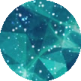


johannezz

[deeplearn.art](https://deeplearn.art)


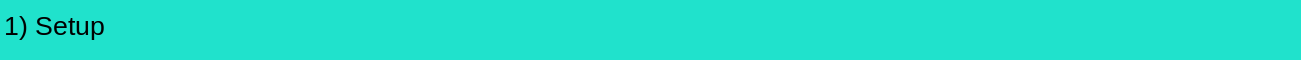



In [ ]:
#@title Check the GPU
!nvidia-smi -L

In [ ]:
#@title Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')



Project Directory must always be given here. It is simply the folder (or a path to subfolder) on Google drive where the primer wav is located. This notebook will put everything else in the same folder.

In [ ]:
#@title Project Directory on Google Drive
PROJECT_DIRECTORY = 'music_co_compose_test' #@param {type:"string"}


**If you are opening earlier project and do not intend to change anything, skip this cell**



---


*Wav*: the name of the primer wav. Do not include .wav file extension.

*Artist*: [pick one from the list](https://raw.githubusercontent.com/deeplearn-art/jukebox/master/artist_genres.txt)

*Genre*:  [pick max. 4 from the list](https://raw.githubusercontent.com/openai/jukebox/master/jukebox/data/ids/v2_genre_ids.txt) 

*Prompt length*: How many seconds do you want to hear your priming wav in the beginning?

*Initial song length*: How many seconds do you want to generate on the initial run? Must be less than 23 seconds.

*Total song length*: How many seconds do you plan the final song to last? Must be at least 25 seconds.

---

**Optional (it's ok if you leave these blank)**

*Lyrics*: Words of a song

*Note*: A note attached to the branches



In [ ]:
#@title Setup your project

from pathlib import Path
import json
import shutil
import os
import glob
import soundfile as sf

WAV = 'black_cow_extract' #@param {type:"string"}
ARTIST= 'steely dan' #@param {type:"string"}
GENRE = "classic rock jazz" #@param {type:"string"}
PROMPT_LENGTH =   25#@param {type:"number"}
INITIAL_SONG_LENGTH =  4#@param {type:"number"}
TOTAL_SONG_LENGTH =  160#@param {type:"number"}
LYRICS = "Under the glow of neon lights, We dance away the endless nights. A secret in your eyes, a touch of haze, But still, I'm captivated by your ways.  With every heartbeat, we synchronize. We lose ourselves, and we harmonize. A hint of something, maybe it's true. But all I want is to be with you.  Oh, I love your sweaty embrace. Lost in the rhythm, we keep up the pace. Maybe you're on something, but it's alright. Together, we'll soar into the night.  Electric energy, we radiate. In each other's arms, we elevate. A connection, magnetic and strong. In this cosmic dance, we belong.  We'll chase the sun, and defy the odds. Dance on the edge, where the wild hearts trod. A secret world, just for you and me. In this blissful state, we're truly free.  In the dawn's light, our love still burns bright. The spell remains, as we hold each other tight. With every breath, we're intertwined. Forever, in this love, we're combined." #@param {type:"string"}
NOTE = "" #@param {type:"string"}

sampling_temperature = .98
hops = [.5, .5, .125] 

tokens_list = [0,0,0]
info = {}
info['PROJECT_DIRECTORY'] = PROJECT_DIRECTORY
info['WAV'] = WAV
info['ARTIST']= ARTIST
info['GENRE'] = GENRE
info['PROMPT_LENGTH'] = PROMPT_LENGTH
info['INITIAL_SONG_LENGTH'] = INITIAL_SONG_LENGTH
info['TOTAL_SONG_LENGTH'] = TOTAL_SONG_LENGTH
info['LYRICS'] = LYRICS
info['NOTE'] = NOTE
info['SONG_LENGTH'] = 0
info['TOKENS'] = tokens_list
project_dir = f'/content/gdrive/MyDrive/{PROJECT_DIRECTORY}'


ckpt = f"{project_dir}/zs-checkpoint.t" 
b_ckpt = f"{project_dir}/zs-checkpoint-b.t" #auto backup for re-run
f_info = f"{project_dir}/info.json"
b_info = f"{project_dir}/b_info.json" #auto backup for re-run

def read_info(f_path):  
  with open(f_path, 'r') as data:
    info = json.load(data)  
  return info  

def save_info(f_path):
  with open(f_path, 'w') as f:
    json.dump(info, f)
    
def print_fancy(txt):
  print('\x1b[0;35m' + txt + '\x1b[0m')

def get_tokens_list(zs):
  # tokens_list is a list variable that tracks the start of the
  # last generated new tokens inside zs. It is stored in
  # the branch dir info.json, so we can upsample only the newly
  # added tokens (see truncate_zs, below)
  tokens_list = [0,0,0]
  for i in range(hps.levels):
    tokens_list[i] = zs[i].shape[1] 
  return tokens_list  

def truncate_zs(zs):
  for i in range(hps.levels):
    zs[i] = zs[i][:,tokens_list[i]:]
  return zs  

def backup(zs, note):
  # makes new branch
  d = datetime.datetime.now()
  date_str = d.strftime("%m-%d-%Y")
  bak_dir = f'{hps.name}/backup-{date_str}-{note}'
  info['PROJECT_DIRECTORY'] = bak_dir
  info['NOTE'] = note
  info["TOKENS"] = tokens_list
  #%mkdir "{bak_dir}"
  Path(bak_dir).mkdir(parents=True, exist_ok=True)
  #%cp "{hps.name}"/*.wav "{bak_dir}"
  for i in range(hps.n_samples):
    shutil.copy(f'{hps.name}/clip_{i}.wav', bak_dir)
  t.save(zs, f'{bak_dir}/zs-checkpoint.t')
  save_info(f'{bak_dir}/info.json')  
  #reset info back to main branch
  info['PROJECT_DIRECTORY'] = hps.name
  info['NOTE'] = ''
  info["TOKENS"] = [0,0,0]
  
def write_audio(start):
  for i in range(hps.n_samples):
     sf.write(f'clip_{i}.wav', x[i][start*hps.sr:], hps.sr)

if not Path(f_info).is_file():
  # TODO experiment with changing info during composing
  save_info(f_info)

info = read_info(f_info)  
INITIAL_SONG_LENGTH = int(info['INITIAL_SONG_LENGTH'])
PROMPT_LENGTH = int(info['PROMPT_LENGTH'])
TOTAL_SONG_LENGTH = int(info['TOTAL_SONG_LENGTH'])
SONG_LENGTH = int(info['SONG_LENGTH'])
song_length = SONG_LENGTH




In [ ]:
#@title  Cache model files and stuff
#save_and_load_models_from_drive = False
save_and_load_models_from_drive = True
model = '5b_lyrics'

#START GDRIVE MODEL LOADER

AZURE_URL="https://openaipublic.azureedge.net"
VMCACHE = "/root/.cache"
GCACHE="/content/gdrive/MyDrive"

if save_and_load_models_from_drive == True:
  import os.path
  #!apt install pv
  !mkdir -p {VMCACHE}/jukebox/models/1b_lyrics {VMCACHE}/jukebox/models/5b_lyrics  {VMCACHE}/jukebox/models/5b
  !mkdir -p {GCACHE}/jukebox/models/5b_lyrics {GCACHE}/jukebox/models/5b {GCACHE}/jukebox/models/1b_lyrics

def cache_load_file(pathFragment):
    basename = os.path.basename(pathFragment)
    if os.path.exists(f"{VMCACHE}/{pathFragment}") == False:
      if os.path.exists(f"{GCACHE}/{pathFragment}") == False:
        print(f"{basename} not stored in Google Drive... downloading it.")
        !wget {AZURE_URL}/{pathFragment} -O {GCACHE}/{pathFragment}
      else:
        print(f"{basename} found in Google Drive.")
      print(f'Copying {basename} from Google Drive to VM')
      !wget {GCACHE}/{pathFragment} -O {VMCACHE}/{pathFragment}

def load_5b_vqvae():
    cache_load_file("jukebox/models/5b/vqvae.pth.tar")

def load_1b_lyrics_level2():
    cache_load_file("jukebox/models/1b_lyrics/prior_level_2.pth.tar")

def load_5b_lyrics_level2():
  cache_load_file("jukebox/models/5b_lyrics/prior_level_2.pth.tar")

def load_5b_level1():
  cache_load_file('jukebox/models/5b/prior_level_1.pth.tar')

def load_5b_level0():
  cache_load_file('jukebox/models/5b/prior_level_0.pth.tar')

def load_5b_level2():
  cache_load_file('jukebox/models/5b/prior_level_2.pth.tar')

if save_and_load_models_from_drive == True:
  if model == '5b_lyrics':
    load_5b_vqvae()
    load_5b_lyrics_level2()
    load_5b_level1()
    load_5b_level0()
  if model == '5b':
    load_5b_vqvae()
    load_5b_level2()
    load_5b_level1()
    load_5b_level0()
  elif model == '1b_lyrics':
    load_5b_vqvae()
    load_1b_lyrics_level2()
    load_5b_level1()
    load_5b_level0()
#END GDRIVE MODEL LOADER



 In general you can extend 2 or 3 clips. 
 
 If you get T4, set the number of clips to 2 woth the following slider. Set it to 3 if you're on "premium" GPU.

In [ ]:
#@title  Set the number of the clips
number_of_clips = 3 #@param {type:"slider", min:1, max:3, step:1}

In [ ]:
#@title Setup and install Jukebox.

!pip install git+https://github.com/deeplearn-art/jukebox-saveopt
import torch as t
import librosa
import datetime
from IPython.display import display, Audio

from jukebox.make_models import make_vqvae, make_prior, MODELS, make_model
from jukebox.hparams import Hyperparams, setup_hparams
from jukebox.sample import sample_single_window, _sample, \
                           sample_partial_window, upsample, \
                           load_prompts
from jukebox.utils.dist_utils import setup_dist_from_mpi
from jukebox.utils.torch_utils import empty_cache
#rank, local_rank, device = setup_dist_from_mpi()

# MPI Connect. MPI doesn't like being initialized twice, hence the following
try:
    if device is not None:
        pass
except NameError:
    rank, local_rank, device = setup_dist_from_mpi()

model = "5b_lyrics" 
hps = Hyperparams()
hps.sr = 44100
hps.n_samples = number_of_clips
hps.name = project_dir
hps.hop_fraction = hops
hps.levels = 3
lower_batch_size = 16
max_batch_size = 2
lower_level_chunk_size =32 #512 #
chunk_size = 16 #256 

vqvae, *priors = MODELS[model]
vqvae = make_vqvae(setup_hparams(vqvae, dict(sample_length = 1048576)), device)
top_prior = make_prior(setup_hparams(priors[-1], dict()), vqvae, device)
mode = 'primed'
# find out if we have saved anything
ckpt =  f'{hps.name}/zs-checkpoint.t'
data = f"{hps.name}/level_1/data.pth.tar"
data_0 = f"{hps.name}/level_0/data.pth.tar"
zs = None    
resume_state = ""
if os.path.exists(hps.name):
  if os.path.isfile(data_0):
    mode = 'upsample'
    codes_file = data_0
    resume_state = "upsampling"
    audio_file=None
  if os.path.isfile(data):
    mode = 'upsample'
    codes_file = data
    resume_state = "upsampling"
    audio_file=None  
  elif os.path.isfile(ckpt):
    resume_state = "composing"  
    
if resume_state != 'upsampling': 
  codes_file=None
  audio_file = f"{project_dir}/{info['WAV']}.wav"

print(f"mode : {mode}")
sample_hps = Hyperparams(dict(mode=mode, codes_file=codes_file, audio_file=audio_file, prompt_length_in_seconds=PROMPT_LENGTH))

sample_length_in_seconds = TOTAL_SONG_LENGTH 
hps.sample_length = (int(sample_length_in_seconds*hps.sr)//top_prior.raw_to_tokens)*top_prior.raw_to_tokens
assert hps.sample_length >= top_prior.n_ctx*top_prior.raw_to_tokens, f'Please choose a larger sampling rate'

metas = [dict(artist = info['ARTIST'],
          genre = info['GENRE'],
          total_length = hps.sample_length,
          offset = 0,
          lyrics = info['LYRICS'],
          ),
        ] * hps.n_samples

if resume_state != 'upsampling': 
  labels = top_prior.labeller.get_batch_labels(metas, 'cuda')
  sampling_kwargs = dict(temp=sampling_temperature, fp16=True, max_batch_size=lower_batch_size,
                    chunk_size=lower_level_chunk_size)    
else:
  labels = [None, None, top_prior.labeller.get_batch_labels(metas, 'cuda')]
  sampling_kwargs = [dict(temp=.99, fp16=True, max_batch_size=lower_batch_size,
                        chunk_size=lower_level_chunk_size),
                    dict(temp=0.99, fp16=True, max_batch_size=lower_batch_size,
                         chunk_size=lower_level_chunk_size),
                    dict(temp=sampling_temperature, fp16=True, 
                         max_batch_size=max_batch_size, chunk_size=chunk_size)]

def seconds_to_tokens(sec, sr, prior, chunk_size):
  tokens = sec * hps.sr // prior.raw_to_tokens
  tokens = ((tokens // chunk_size) + 1) * chunk_size
  print(f"tokens {tokens} prior.n_ctx {prior.n_ctx}")
  assert tokens <= prior.n_ctx, 'The continuation length exceeds 23 seconds!'
  #if tokens > prior.n_ctx:
  #  tokens = prior.n_ctx
  return tokens

def get_length():
  the_length = 0
  level_0_wav = glob.glob(os.path.join(hps.name, 'level_0/*0.wav'))
  level_1_wav = glob.glob(os.path.join(hps.name, 'level_1/*0.wav'))
  if level_0_wav != []:
    print_fancy("resuming level_0")
    the_length = librosa.get_duration(filename=level_0_wav[0]) 
  elif level_1_wav != []:
    print_fancy("resuming level_1")
    the_length = librosa.get_duration(filename=level_1_wav[0]) 
  elif resume_state ==  'composing':
    the_length = info["SONG_LENGTH"]   
  return the_length

if resume_state != "":   
  print_fancy(f'Resuming execution, state: {resume_state}. Rendered length {int(get_length())} sec.')





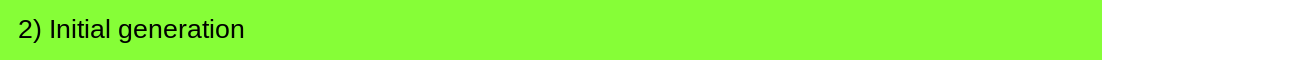

This will generate the starting point of your song.

If you are returning to an earlier session / branch skip this step. 

If you are not sure, check the violet text in the previous cells output

In [ ]:
#@title Generate the beginning of your song

if resume_state == '':
  if os.path.isfile(ckpt):
    # redo initial generation
    #!rm {ckpt}
    os.remove(ckpt) 
    #!rm -r {hps.name}/level_2
    os.rmtree(f'{hps.name}/level_2')

  assert sample_hps.audio_file is not None
  audio_files = sample_hps.audio_file.split(',')
  duration = (int(sample_hps.prompt_length_in_seconds*hps.sr)//top_prior.raw_to_tokens)*top_prior.raw_to_tokens
  tokens_to_sample = seconds_to_tokens(INITIAL_SONG_LENGTH, hps.sr, top_prior, chunk_size)  

  x = load_prompts(audio_files, duration, hps)
  zs = top_prior.encode(x, start_level=0, end_level=len(priors), bs_chunks=x.shape[0])
  
  zs = sample_partial_window(zs, labels, sampling_kwargs, 2, top_prior, tokens_to_sample, hps)
  x = vqvae.decode(zs[2:], start_level=2).cpu().numpy()
  song_length = INITIAL_SONG_LENGTH
  print_fancy(f"Song length: {song_length} seconds. Remaining time: {TOTAL_SONG_LENGTH - song_length}") 
  write_audio(0)      
  t.save(zs, ckpt)
  #!cp /content/clip_*.wav {hps.name}
  for i in range(hps.n_samples):
    shutil.copy(f'/content/clip_{i}.wav', hps.name)
  info["SONG_LENGTH"] = song_length
  save_info(f_info)
  # initial generation done, we enter into mode
  resume_state = "composing"
  empty_cache()

Once the initial generation has finished, you can listen the  clips.   

In [ ]:
#@title Open clips
if resume_state != "data":
  audios = []
  for i in range(hps.n_samples):
    print(f'Clip {i}')
    display(Audio(f'clip_{i}.wav'))



If you didn't like any of the initial clips, just go back to *Initial generation* and run the first cell again.

If there is one that you like, proceed to the next section ("Add to the composition").

If there are more than one that you like, run the cell below to make a "new branch" that you can work with later. The branch saves only what has been added since the last round of generation.

 Then pick one to extend now and proceed to the next section ("Add to the composition").

In [ ]:
#@title Make a branch for later use
NOTE = '' #@param {type:"string"}
backup(zs,NOTE)
#read_info(hps.name)


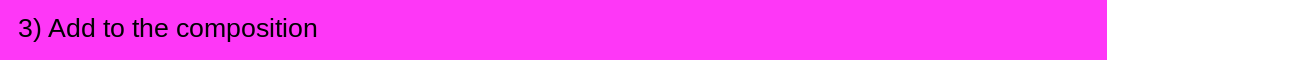


You have now generated the start of your song. Here you input options for continuing the song. You'll return here to extend the song until you're ready to render the final tune.

**run_again**: only if you already ran this cell but weren't happy with the result.

**Choice**: the number (0,1,2) of the clip you wish to extend. The clips can be found in the project folder.

**Addition length**: How many seconds are you going to add to the song? 

**Playback start**: How many seconds (if any) do you wish to skip on playback?

In [ ]:
#@title Input song continuation options
run_again = False #@param {type:"boolean"}
CHOICE =  2#@param {type:"number"}
ADDITION_LENGTH =  4#@param {type:"number"}
PLAYBACK_START =  142#@param {type:"number"}

In [ ]:
#@title Continue generating the song
empty_cache()


if resume_state != "data":
  if run_again:
     if os.path.isfile(b_ckpt) and os.path.isfile(b_info):
       #!cp {b_ckpt} {ckpt}
       shutil.copy(b_ckpt,ckpt)
       #!cp {b_info} {f_info}
       shutil.copy(b_info,f_info)
     else:
       print("Failed to run again")  
  else:           
    #!cp {ckpt} {b_ckpt}
    shutil.copy(ckpt,b_ckpt)
    #!cp {f_info} {b_info}
    shutil.copy(f_info,b_info)
  
  info = read_info(f_info)
  song_length = info["SONG_LENGTH"]
  zs=t.load(ckpt) 
  
  tokens_list = get_tokens_list(zs)
  # generate music
 
  zs[2]=zs[2][CHOICE].repeat(hps.n_samples,1)

  tokens_to_sample = seconds_to_tokens(ADDITION_LENGTH, hps.sr, top_prior, chunk_size)  
  print(f"tokens to sample : {tokens_to_sample}")
  zs = sample_partial_window(zs, labels, sampling_kwargs, 2, top_prior, tokens_to_sample, hps)
  
  empty_cache()
  x = vqvae.decode(zs[2:], start_level=2).cpu().numpy()
  #write audio clips
  write_audio(PLAYBACK_START)

  # write checkpoint
  song_length += ADDITION_LENGTH
  print_fancy(f"Song length: {song_length} seconds. Remaining time: {TOTAL_SONG_LENGTH - song_length}") 
  t.save(zs, f'{hps.name}/zs-checkpoint.t')
  #!cp /content/clip_*.wav "{hps.name}"
  for i in range(hps.n_samples):
    shutil.copy(f'/content/clip_{i}.wav', hps.name)
  info["SONG_LENGTH"] = song_length
  save_info(f_info)
  empty_cache()

In [ ]:
#@title Open clips
if resume_state != "data":
  audios = []
  for i in range(hps.n_samples):
    print(f'Clip {i}')
    display(Audio(f'clip_{i}.wav'))


To keep on extending the song, return to **Add to the composition** , input your choices and run the cells again.

If you didn't like any of the clips, check the ***run_again*** checkbox and run the **Continue generating** cell again. (Remember to uncheck it when you're done!)

If your song is getting near the full length, or you are happy with it as it is now, proceed to the next section to upsample.

If there are more than one that you like, run the cell below to make a "new branch" that you can work with later.

In [ ]:
#@title Make a branch for later use
NOTE = 'good stuff' #@param {type:"string"}
backup(zs,NOTE)


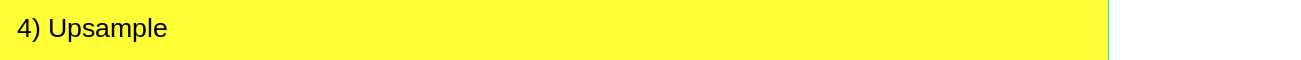

It remains for you to choose the clip to be rendered to better quality audio.

If on the other hand you would like to render all of them at the same time, leave CHOICE as "None" (Be aware that this increases the upsampling time)

There are two upsampling levels: level_1 and level_0 (The noisy initial generation is level_2). The less the level number, the better it sounds.

When the upsampling is done, the results can be found in new folders called **level_1**, **level_0** inside your project directory. 

If you are upsampling a branch from previous session, you can also *truncate* the branch, so that it upsamples only that part of the song which is new.



In [ ]:
#@title Upsampling settings

CHOICE = 0 #@param {type:"raw"}
truncate = False #@param {type:"boolean"}
zs=t.load(ckpt) 
info = read_info(f_info)
tokens_list = info["TOKENS"]
if truncate:
  zs = truncate_zs(zs)
if CHOICE is not None:   
  hps.n_samples = 1
  CHOICE = int(CHOICE)
  #prune all but the choice 
  nzs = []
  for i in range(len(zs)):
    zs_lvl = t.zeros(1, zs[i].shape[1],dtype=t.int64)
    zs_lvl[0] = zs[i][CHOICE]
    nzs.append(zs_lvl)
  
  metas = [dict(artist = info['ARTIST'],
          genre = info['GENRE'],
          total_length = hps.sample_length,
          offset = 0,
          lyrics = info['LYRICS'],
          ),]   
else:
  nzs = zs    

t.save(nzs,f'{hps.name}/zs-checkpoint-final.t')
# values for speed upsampling 

hps.hop_fraction = [1, 1, .125] 


In [ ]:
#@title Upsample your favorite clip 

if (resume_state != "upsampling"):
  zs = t.load(f'{hps.name}/zs-checkpoint-final.t')
  assert zs[2].shape[1]>=2048, f'Please first generate at least 2048 tokens at the top level, currently you have {zs[2].shape[1]}'
  hps.sample_length = zs[2].shape[1]*top_prior.raw_to_tokens 
  del top_prior
  empty_cache()
  top_prior=None
  upsamplers = [make_prior(setup_hparams(prior, dict()), vqvae, 'cpu') for prior in priors[:-1]]
  sampling_kwargs = [dict(temp=.99, fp16=True, max_batch_size=16, chunk_size=32),
                    dict(temp=0.99, fp16=True, max_batch_size=16, chunk_size=32),
                    None]
  if type(labels)==dict:
    labels = [prior.labeller.get_batch_labels(metas, 'cuda') for prior in upsamplers] + [labels] 
  

else: #upsampling from level 1
  assert sample_hps.codes_file is not None
  data = t.load(sample_hps.codes_file, map_location='cpu')
  zs = [z.cuda() for z in data['zs']]
  assert zs[-1].shape[0] == hps.n_samples, f"Expected bs = {hps.n_samples}, got {zs[-1].shape[0]}"
  del data
  del top_prior
  empty_cache()
  top_prior=None
  upsamplers = [make_prior(setup_hparams(prior, dict()), vqvae, 'cpu') for prior in priors[:-1]]
  labels[:2] = [prior.labeller.get_batch_labels(metas, 'cuda') for prior in upsamplers]
  
zs = upsample(zs, labels, sampling_kwargs, [*upsamplers, top_prior], hps)
del upsamplers
empty_cache()
print("Done.")

from google.colab import runtime
runtime.unassign()